# Postprocessing the data

# Censor Mask

In [1]:
from glob import glob
from os.path import join as pjoin
import numpy as np
import pandas as pd
import re
import pickle
from tqdm import tqdm
roi_lookup=np.load('/Users/sabatb/Documents/morerois/roi_lookup.npy', allow_pickle=True).item()

In [8]:
from nilearn.image import load_img, new_img_like
import numpy as np
atlas= load_img('/Users/sabatb/Documents/morerois/extras/Symmetric_N162_space-indiv3d_brain.nii.gz')
da = np.array(atlas.dataobj)
print(np.max(da))

6288


In [9]:
#proj_path = '/Users/sabatb/Documents/new version data'
#fmri_path='/Users/sabatb/Documents/new version data/bold-2/rabies-hp'
#ca_path = pjoin(proj_path,'ca2')
bold_path = '/Users/sabatb/Documents/morerois/rabies-hp-2/'
#pkl_path = pjoin(proj_path,'pkl')
#ca_files = sorted(glob(pjoin(ca_path,'*.npy')))
bold_files = sorted(glob(pjoin(bold_path,'*rabies*.npy')))
censor_path='/Users/sabatb/Documents/morerois/censor/'
censor_files=sorted(glob(pjoin(censor_path,'*.csv')))

In [10]:
df_cols = ['sub','ses','run','task','censor']
df_data = {col:[] for col in df_cols}
for fname in tqdm(censor_files[:]):
    censor = pd.read_csv(fname) # time X rois
    # timeseries = interp_nan(timeseries)
    sub = re.compile('sub-SLC[0-9]*').findall(fname)[0]
    ses = re.compile('ses-[0-9]*').findall(fname)[0]
    run = re.compile('run-[0-9]*').findall(fname)[0]
    task = re.compile('task-[a-z]*').findall(fname)[0]
    # TODO: need to handle NaN values, zscore timeseries etc.
    for col in df_cols:
        df_data[col].append(eval(col))

censor_df = pd.DataFrame(df_data)

100%|██████████| 185/185 [00:00<00:00, 1383.49it/s]


In [11]:
censor_led_df = censor_df[censor_df['task']=='task-led'].reset_index()
print(f'Total bold led data runs : {censor_led_df.shape[0]}')

Total bold led data runs : 74


In [12]:
df_censor=censor_led_df
df_censor.head()

,index,sub,ses,run,task,censor
0,0,sub-SLC01,ses-1,run-2,task-led,False = Masked Frames 0 ...
1,1,sub-SLC01,ses-1,run-6,task-led,False = Masked Frames 0 ...
2,6,sub-SLC01,ses-2,run-2,task-led,False = Masked Frames 0 ...
3,7,sub-SLC01,ses-2,run-4,task-led,False = Masked Frames 0 ...
4,8,sub-SLC01,ses-2,run-6,task-led,False = Masked Frames 0 ...


In [31]:
b=[]
for i in range (len(df_censor)):
    if  df_censor['sub'][i]=='sub-SLC10':
        m=0
        for i_censor in df_censor['censor'][i].index:
            dfm=df_censor['censor'][i].iloc[i_censor]
            dfm=dfm.to_string(index=False)
            if dfm == "True":
                b.append(1)
            if dfm == "False":
                b.append(0)
        

In [32]:
censor_labels=np.array(b)
censor_labels=np.expand_dims(censor_labels, axis=0)
censor_labels=censor_labels.reshape(-1, 1)
print(censor_labels.shape)
np.savetxt("/Users/sabatb/Desktop/newdata/subj10/censor_labels_subj10.1D",censor_labels,fmt='%.3f', delimiter='\t')

(5400, 1)


# data

#adding 0 to removed ROIs

In [40]:
removed_roi=[]
for i in range (6288):
    if i not in roi_lookup['bold'].values():
        removed_roi.append(i-1)
removed_roi.pop(0)

-1

In [41]:
print((removed_roi))

[470, 472, 507, 508, 510, 511, 522, 570, 572, 714, 796, 846, 931, 984, 990, 991, 994, 995, 997, 999, 1002, 1006, 1007, 1010, 1013, 1014, 1017, 1021, 1025, 1028, 1029, 1033, 1034, 1036, 1037, 1040, 1041, 1044, 1045, 1048, 1052, 1054, 1058, 1062, 1065, 1066, 1068, 1082, 1084, 1095, 1096, 1098, 1099, 1104, 1112, 1117, 1119, 1128, 1142, 1147, 1154, 1178, 1204, 1226, 1232, 1239, 1256, 1262, 1281, 1288, 1304, 1328, 1352, 1355, 1356, 1363, 1373, 1378, 1388, 1394, 1395, 1397, 1402, 1410, 1413, 1414, 1417, 1430, 1433, 1443, 1444, 1450, 1458, 1462, 1464, 1466, 1467, 1468, 1470, 1472, 1473, 1476, 1478, 1480, 1483, 1485, 1486, 1488, 1489, 1493, 1494, 1495, 1496, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1511, 1512, 1514, 1517, 1518, 1524, 1525, 1526, 1527, 1529, 1531, 1532, 1534, 1535, 2006, 2008, 2043, 2044, 2046, 2047, 2058, 2106, 2108, 2467, 2520, 2526, 2527, 2530, 2531, 2538, 2542, 2543, 2546, 2549, 2550, 2553, 2557, 2561, 2564, 2565, 2569, 2570, 2572, 2573, 2576, 2577, 2580, 2581,

#concatinate

In [42]:
df_cols = ['sub','ses','run','task','timeseries']
df_data = {col:[] for col in df_cols}
for fname in tqdm(bold_files[:]):
    timeseries = np.load(fname) # time X rois
    # timeseries = interp_nan(timeseries)
    sub = re.compile('sub-SLC[0-9]*').findall(fname)[0]
    ses = re.compile('ses-[0-9]*').findall(fname)[0]
    run = re.compile('run-[0-9]*').findall(fname)[0]
    task = re.compile('task-[a-z]*').findall(fname)[0]
    # TODO: need to handle NaN values, zscore timeseries etc.
    for col in df_cols:
        df_data[col].append(eval(col))

bold_df = pd.DataFrame(df_data)

100%|██████████| 184/184 [00:02<00:00, 86.55it/s] 


In [43]:
bold_led_df = bold_df[bold_df['task']=='task-led'].reset_index()
print(f'Total bold led data runs : {bold_led_df.shape[0]}')

Total bold led data runs : 74


In [44]:
df=bold_led_df
df.head()

,index,sub,ses,run,task,timeseries
0,1,sub-SLC01,ses-1,run-2,task-led,"[[42.04031753540039, -85.56024932861328, 60.78..."
1,4,sub-SLC01,ses-1,run-6,task-led,"[[-15.675268173217773, -46.53158950805664, 183..."
2,7,sub-SLC01,ses-2,run-2,task-led,"[[74.88526153564453, -42.07335662841797, 99.81..."
3,9,sub-SLC01,ses-2,run-4,task-led,"[[202.51380920410156, 51.093231201171875, -20...."
4,11,sub-SLC01,ses-2,run-6,task-led,"[[-9.184001922607422, 1.413281798362732, -71.1..."


In [46]:
print(df['timeseries'][0].shape)

(6017, 372)


In [48]:

df['newdata'] = ''
for i in range (len(df['timeseries'])):
    m=0
    new_data=np.zeros((6288,df['timeseries'][i].shape[1]))
    for k in range (6288):
        if k not in removed_roi:
            new_data[k,:]=df['timeseries'][i][m,:]
            m=m+1
    df['newdata'][i]=new_data 


/var/folders/ts/pxmrjx2561j3jjvs7c2bt6440000gp/T/ipykernel_62481/4191615050.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['newdata'][i]=new_data


In [49]:
df['likeraw'] = ''
for i in range (len(df_censor)):
    b=[]
    for i_censor in df_censor['censor'][i].index:
        dfm=df_censor['censor'][i].iloc[i_censor]
        dfm=dfm.to_string(index=False)
        if dfm == "False":
            b.append(i_censor)
    lk_raw=np.zeros((6288,600))
    m=0
    for k in range (600):
        if k not in b:
            lk_raw[:,k]=df['newdata'][i][:,m]
            m=m+1
        
                
    df['likeraw'][i] =np.nan_to_num(lk_raw)
            
        

/var/folders/ts/pxmrjx2561j3jjvs7c2bt6440000gp/T/ipykernel_62481/4061369249.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['likeraw'][i] =np.nan_to_num(lk_raw)


In [54]:
print(df['newdata'][0].shape)

(6288, 372)


In [55]:
df.head()

,index,sub,ses,run,task,timeseries,newdata,likeraw
0,1,sub-SLC01,ses-1,run-2,task-led,"[[42.04031753540039, -85.56024932861328, 60.78...","[[42.04031753540039, -85.56024932861328, 60.78...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,sub-SLC01,ses-1,run-6,task-led,"[[-15.675268173217773, -46.53158950805664, 183...","[[-15.675268173217773, -46.53158950805664, 183...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,7,sub-SLC01,ses-2,run-2,task-led,"[[74.88526153564453, -42.07335662841797, 99.81...","[[74.88526153564453, -42.07335662841797, 99.81...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9,sub-SLC01,ses-2,run-4,task-led,"[[202.51380920410156, 51.093231201171875, -20....","[[202.51380920410156, 51.093231201171875, -20....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,11,sub-SLC01,ses-2,run-6,task-led,"[[-9.184001922607422, 1.413281798362732, -71.1...","[[-9.184001922607422, 1.413281798362732, -71.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


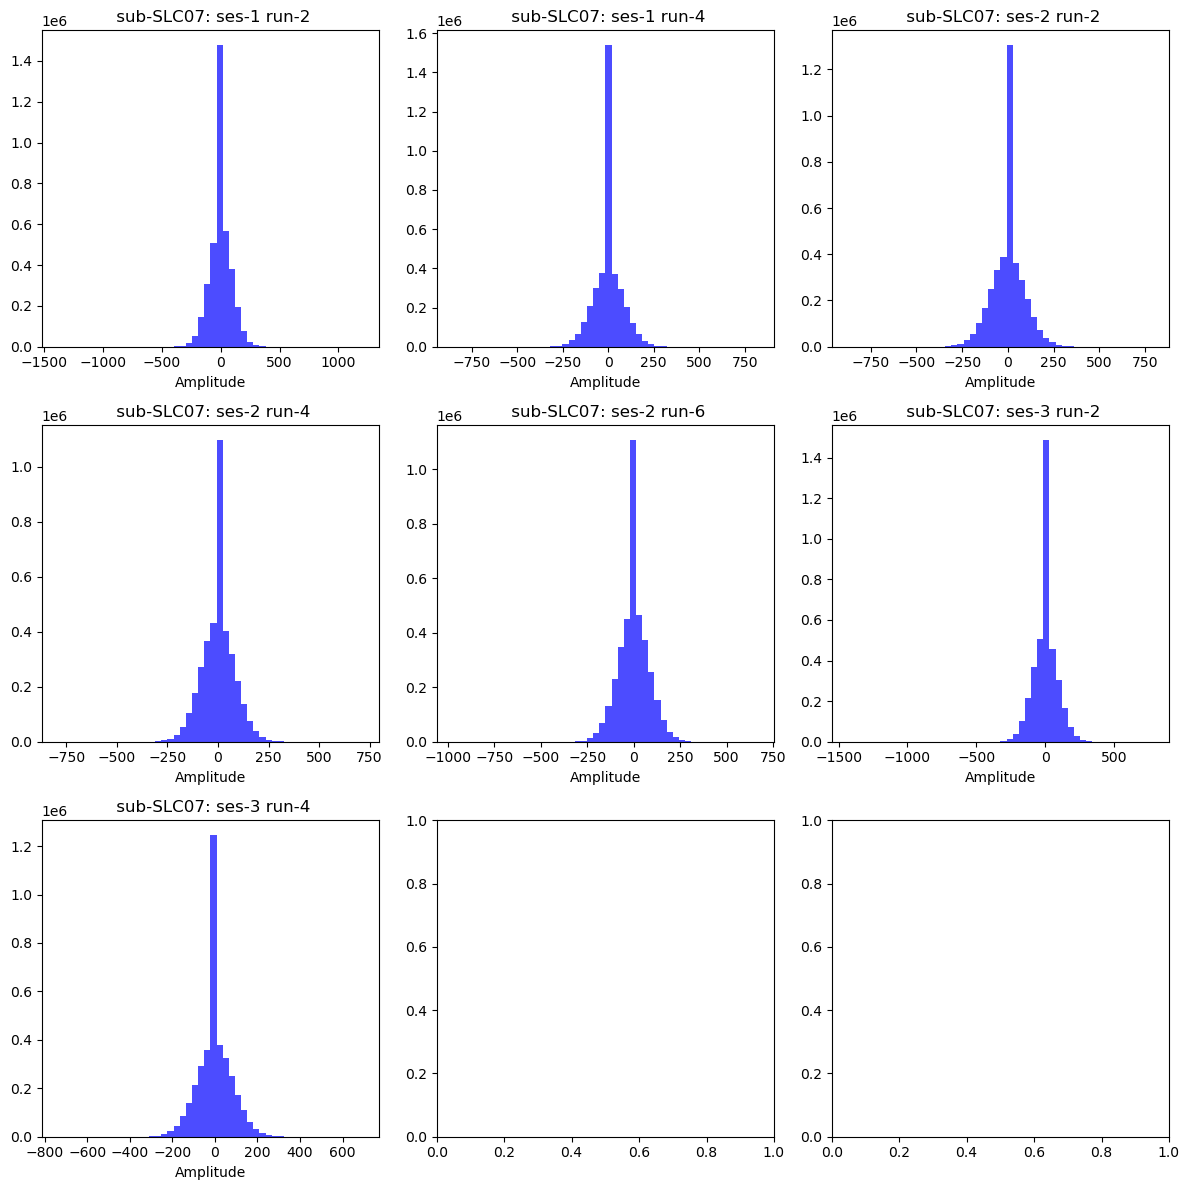

In [56]:
import numpy as np
import matplotlib.pyplot as plt

rows = 3  
cols = 3 
subject='sub-SLC07'
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
k = 0

for mat in range(len(df['likeraw'])):
    if df['sub'][mat]==subject:
        matrix = df['likeraw'].iloc[mat]
        flattened_values = matrix.flatten()
        ax = axes[k // cols, k % cols] 
        ax.hist(flattened_values, bins=50, color='blue', alpha=0.7)
        ax.set_xlabel('Amplitude')
        ax.set_title(f' {df["sub"][mat]}: {df["ses"][mat]} {df["run"][mat]}')
    
        k += 1
        if k >= rows * cols:
            break

plt.tight_layout()
plt.show()
#sub-SLC07: ses-3 run-6     : mat=53

In [94]:
k1=0
for i in range (len(df['likeraw'])):
    if df['sub'][i]=='sub-SLC10':
        if k1==0:
            result_1=df['likeraw'][i]
            k1=k1+1
        else:
            result_1 = np.concatenate((result_1, df['likeraw'][i]), axis=1)

In [95]:
#result_1=np.transpose(result_1)
print(result_1.shape)

(6288, 5400)


In [96]:
np.savetxt("/Users/sabatb/Desktop/newdata/subj10/led_concatinated_subj10.1D",result_1,fmt='%.3f',delimiter='\t') 

# starting times

In [115]:
starting_times=[]
starting_times.append(0)
summ=0
for i in range (len(df['likeraw'])):
    if df['sub'][i]=='sub-SLC10':
        summ=summ+df['likeraw'][i].shape[1]
        starting_times.append(summ)
starting_times=starting_times[:-1]    

In [116]:
starting_times=np.array(starting_times)
starting_times=np.expand_dims(starting_times, axis=0)
np.savetxt("/Users/sabatb/Desktop/newdata/subj10/starting_times_subj10.1D",starting_times,fmt='%.3f', delimiter='\t')

# stimuli onset

In [117]:
proj_path='/Users/sabatb/Documents/morerois/'
stim_path=pjoin(proj_path,'stim')
stim_files=sorted(glob(pjoin(stim_path,'*.csv')))

df_cols = ['sub','ses','run','task','stim']
df_data = {col:[] for col in df_cols}
for fname in tqdm(stim_files[:]):
    stim = pd.read_csv(fname) # time X rois

    # timeseries = interp_nan(timeseries)
    sub = re.compile('sub-SLC[0-9]*').findall(fname)[0]
    ses = re.compile('ses-[0-9]*').findall(fname)[0]
    run = re.compile('run-[0-9]*').findall(fname)[0]
    task = re.compile('task-[a-z]*').findall(fname)[0]
    # TODO: need to handle NaN values, zscore timeseries etc.
    for col in df_cols:
        df_data[col].append(eval(col))

stim_df = pd.DataFrame(df_data)

100%|██████████| 94/94 [00:00<00:00, 629.52it/s]


In [118]:
stim_led_df = stim_df[stim_df['task']=='task-led'].reset_index()
print(f'Total bold led data runs : {stim_led_df .shape[0]}')

Total bold led data runs : 74


In [119]:
df_stim=stim_led_df
df_stim.head()


,index,sub,ses,run,task,stim
0,0,sub-SLC01,ses-1,run-2,task-led,Unnamed: 0 ledStim1Hz ledStim10Hz 0 ...
1,1,sub-SLC01,ses-1,run-6,task-led,Unnamed: 0 ledStim1Hz ledStim10Hz 0 ...
2,2,sub-SLC01,ses-2,run-2,task-led,Unnamed: 0 ledStim1Hz ledStim10Hz 0 ...
3,4,sub-SLC01,ses-2,run-4,task-led,Unnamed: 0 ledStim1Hz ledStim10Hz 0 ...
4,6,sub-SLC01,ses-2,run-6,task-led,Unnamed: 0 ledStim1Hz ledStim10Hz 0 ...


In [166]:
m=0
stim_starting=np.zeros((9,9))
for i in range (len(df_stim['stim'])):
    if df_stim['sub'][i]=='sub-SLC10':
        df_stim['stim'][i].drop(columns = df_stim['stim'][i].columns[0], axis = 1, inplace= True)
        df_stim['stim'][i].drop(columns = df_stim['stim'][i].columns[1], axis = 1, inplace= True)    
        result = np.where(df_stim['stim'][i] == 1)[0]
        res = []
        res.append(result[0])
        for idx in range(1, len(result)):
            if result[idx] - result[idx-1] >6:
                res.append(result[idx])
        res = res[:-1]
        stim_starting[m,:]=res
        m=m+1



In [167]:
m1=0
for i in range (len(df_stim['stim'])):
    if df_stim['sub'][i]=='sub-SLC10':
        m1=m1+1
    
print(m1)   

9


In [168]:
print(stim_starting)

[[ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 11.  71. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]
 [ 10.  70. 130. 190. 250. 310. 370. 430. 490.]]


In [169]:
np.savetxt("/Users/sabatb/Desktop/newdata/subj10/stim_times_subj10.1D",stim_starting,fmt='%.3f', delimiter='\t')

In [178]:
print((np.loadtxt("/Users/sabatb/Desktop/newdata/subj06/stim_times_subj06.1D")).shape)
print((np.loadtxt("/Users/sabatb/Desktop/newdata/subj06/starting_times_subj06.1D")).shape)
print((np.loadtxt("/Users/sabatb/Desktop/newdata/subj06/led_concatinated_subj06.1D")).shape)

(7, 9)
(7,)
(6288, 4200)


# Analysis Part after getting B parameters (CSPLIN)

In [1]:
import numpy as np
subj1=np.loadtxt('/Users/sabatb/Desktop/newdata/output01/subj01_bucket_REML.1D')
subj2=np.loadtxt('/Users/sabatb/Desktop/newdata/output02/subj02_bucket_REML.1D')
subj3=np.loadtxt('/Users/sabatb/Desktop/newdata/output03/subj03_bucket_REML.1D')
subj4=np.loadtxt('/Users/sabatb/Desktop/newdata/output04/subj04_bucket_REML.1D')
subj5=np.loadtxt('/Users/sabatb/Desktop/newdata/output05/subj05_bucket_REML.1D')
subj6=np.loadtxt('/Users/sabatb/Desktop/newdata/output06/subj06_bucket_REML.1D')
subj7=np.loadtxt('/Users/sabatb/Desktop/newdata/output07/subj07_bucket_REML.1D')
subj8=np.loadtxt('/Users/sabatb/Desktop/newdata/output08/subj08_bucket_REML.1D')
subj9=np.loadtxt('/Users/sabatb/Desktop/newdata/output09/subj09_bucket_REML.1D')
subj10=np.loadtxt('/Users/sabatb/Desktop/newdata/output10/subj10_bucket_REML.1D')

In [2]:
subj1_betta=subj1[:, 1:-1]
subj2_betta=subj2[:, 1:-1]
subj3_betta=subj3[:, 1:-1]
subj4_betta=subj4[:, 1:-1]
subj5_betta=subj5[:, 1:-1]
subj6_betta=subj6[:, 1:-1]
subj7_betta=subj7[:, 1:-1]
subj8_betta=subj8[:, 1:-1]
subj9_betta=subj9[:, 1:-1]
subj10_betta=subj10[:, 1:-1]

In [181]:
print(subj1_betta.shape)

(6288, 26)


In [3]:
avg=np.zeros_like(subj1_betta)
for roi in range (subj1_betta.shape[0]):
    for time in range (subj1_betta.shape[1]):
        avg[roi,time]=(subj1_betta[roi,time]+subj2_betta[roi,time]+subj3_betta[roi,time]+subj4_betta[roi,time]+subj5_betta[roi,time]+subj6_betta[roi,time]+subj7_betta[roi,time]+subj8_betta[roi,time]+subj9_betta[roi,time]+subj10_betta[roi,time])/10
        
        
    

In [216]:
print(avg.shape)

(6288, 26)


In [ ]:
VISp_left=[108,109,117,119,236,237,239,245,247,364,365,367,373,375]

In [ ]:
VISp_right=[492,493,501,503,620,621,623,629,631,748,749,751,757,759]

In [24]:
std_left=(np.std(avg[VISp_left, :], axis=0))
std_right=(np.std(avg[VISp_right, :], axis=0))

In [25]:
VISp_averages_left = np.mean(avg[VISp_left, :], axis=0)

In [26]:
VISp_averages_right = np.mean(avg[VISp_right, :], axis=0)

In [27]:
# Calculate the standard deviation
std_error_l = std_left/np.sqrt(len(VISp_averages_left))
std_error_r = std_right/np.sqrt(len(VISp_averages_right))


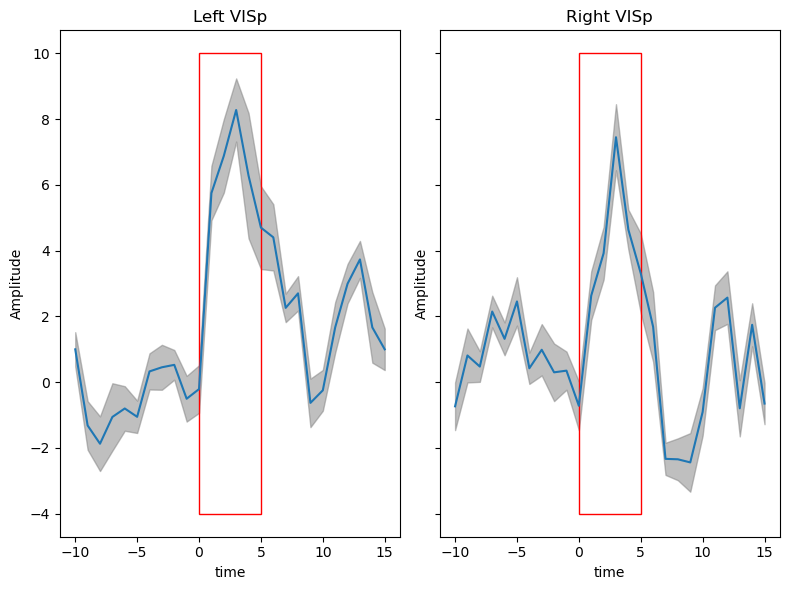

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
t=np.arange(-10, 16)
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True,sharey=True, figsize=(8, 6))

# Plotting on the first subplot
axes[0].plot(t, VISp_averages_left)
axes[0].fill_between(t, VISp_averages_left - std_error_l, VISp_averages_left + std_error_l, color='gray', alpha=0.5)  
rect = Rectangle((0, -4), 5, 14, linewidth=1, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)  # Add the rectangle to the plot
axes[0].set_xlabel('time')
axes[0].set_title('Left VISp')
axes[0].set_ylabel('Amplitude')
# Plotting on the second subplot
axes[1].plot(t, VISp_averages_right)
axes[1].fill_between(t, VISp_averages_right - std_error_r, VISp_averages_right + std_error_r, color='gray', alpha=0.5) 
rect = Rectangle((0, -4), 5, 14, linewidth=1, edgecolor='red', facecolor='none')
axes[1].add_patch(rect)  # Add the rectangle to the plot
axes[1].set_xlabel('time')
axes[1].set_title('Right VISp')
axes[1].set_ylabel('Amplitude')

# Add a common x-axis label
#fig.text(-10, 15, 'X-axis', ha='center')

# Adjust layout and spacing
plt.tight_layout()
plt.savefig('VISp.png')
# Show the plots
plt.show()


# Preparing for Timeseries Visulaization 

In [11]:
from nilearn.image import load_img, new_img_like
import numpy as np

In [12]:
atlas= load_img('/Users/sabatb/Documents/morerois/extras/Symmetric_N162_space-indiv3d_brain.nii.gz')

In [13]:
dataobj = np.array(atlas.dataobj)
print('Number of ROIs in Atlas :',np.max(dataobj))
print('Shape of Atlas :',dataobj.shape)
new_data=np.zeros_like(dataobj)

Number of ROIs in Atlas : 6288
Shape of Atlas : (60, 46, 81)


In [14]:
print(f"total voxels = {dataobj.shape[0]*dataobj.shape[1]*dataobj.shape[2]}")
print(f"voxels in the brain = {(dataobj>0).sum()}")

total voxels = 223560
voxels in the brain = 38193


In [188]:

t=avg.shape[1]
number_of_ROIs=avg.shape[0]
all_times=[]
for time in range (t):
    new_dataobj=np.zeros_like(dataobj,dtype='float')
    for idx_roi in range(number_of_ROIs):
        #print(f"number of voxels in ROI{idx_roi+1} = {(dataobj==(idx_roi+1)).sum()}")
        roi_indices = dataobj==(idx_roi+1)
        new_dataobj[roi_indices] = avg[idx_roi,time]
    all_times.append(new_dataobj)

all_times = np.stack(all_times,axis=-1)
print(all_times.shape)

(60, 46, 81, 26)


In [189]:
timeseries_nii = new_img_like(ref_niimg=atlas, data=all_times, copy_header=True)
timeseries_nii.to_filename('/Users/sabatb/Desktop/newdata/timeseries_all_LED_unassumed26seconds.nii.gz')


# Splitting data into during stimulation and during no stimulation

In [6]:
#avergae
def avg_data(data):
    nostim=np.nanmean(data[:, :10], axis=1)
    stim=np.nanmean(data[:, 10:15], axis=1)
    return nostim,stim

In [7]:
nostim_subj01,stim_subj01 =avg_data(subj1_betta)
nostim_subj02,stim_subj02 =avg_data(subj2_betta)
nostim_subj03,stim_subj03 =avg_data(subj3_betta)
nostim_subj04,stim_subj04 =avg_data(subj4_betta)
nostim_subj05,stim_subj05 =avg_data(subj5_betta)
nostim_subj06,stim_subj06 =avg_data(subj6_betta)
nostim_subj07,stim_subj07 =avg_data(subj7_betta)
nostim_subj08,stim_subj08 =avg_data(subj8_betta)
nostim_subj09,stim_subj09 =avg_data(subj9_betta)
nostim_subj10,stim_subj10 =avg_data(subj10_betta)


In [9]:
print(np.max(stim_subj02))

36.45154000000001


In [34]:

def convert (avg):
    atlas= load_img('/Users/sabatb/Documents/morerois/extras/Symmetric_N162_space-indiv3d_brain.nii.gz')
    dataobj = np.array(atlas.dataobj)
    number_of_ROIs=avg.shape[0]
    new_dataobj=np.zeros_like(dataobj,dtype='float')
    for idx_roi in range(number_of_ROIs):
        #print(f"number of voxels in ROI{idx_roi+1} = {(dataobj==(idx_roi+1)).sum()}")
        roi_indices = dataobj==(idx_roi+1)
        new_dataobj[roi_indices] = avg[idx_roi]
    return new_dataobj
new_dataobj=convert(stim_subj10)
timeseries_nii = new_img_like(ref_niimg=atlas, data=new_dataobj, copy_header=True)
timeseries_nii.to_filename('/Users/sabatb/Desktop/newdata/average/stim_subj10.nii.gz')

# paired t test

In [33]:
during_stim=np.empty((2782,10)); during_stim[:]=np.nan
during_nostim=np.empty((2782,10)); during_nostim[:]=np.nan
for i in range (2782):
    m=0
    during_stim[i,m]=stim_subj01[i]
    during_nostim[i,m]=nostim_subj01[i]
    m=m+1
    during_stim[i,m]=stim_subj02[i]
    during_nostim[i,m]=nostim_subj02[i]
    m=m+1
    during_stim[i,m]=stim_subj03[i]
    during_nostim[i,m]=nostim_subj03[i]
    m=m+1
    during_stim[i,m]=stim_subj04[i]
    during_nostim[i,m]=nostim_subj04[i]
    m=m+1
    during_stim[i,m]=stim_subj05[i]
    during_nostim[i,m]=nostim_subj05[i]
    m=m+1
    during_stim[i,m]=stim_subj06[i]
    during_nostim[i,m]=nostim_subj06[i]
    m=m+1
    during_stim[i,m]=stim_subj07[i]
    during_nostim[i,m]=nostim_subj07[i]
    m=m+1
    during_stim[i,m]=stim_subj08[i]
    during_nostim[i,m]=nostim_subj08[i]
    m=m+1
    during_stim[i,m]=stim_subj09[i]
    during_nostim[i,m]=nostim_subj09[i]
    m=m+1
    during_stim[i,m]=stim_subj10[i]
    during_nostim[i,m]=nostim_subj10[i]
    m=m+1

In [94]:
from scipy import stats
pvalue=np.empty((2782)); pvalue[:]=np.nan
statistic=np.empty((2782)); statistic[:]=np.nan
for i in range (2782):
    statistic[i]=scipy.stats.ttest_rel(during_stim[i], during_nostim[i])[0]
    pvalue[i]=scipy.stats.ttest_rel(during_stim[i], during_nostim[i])[1]
np.save('statistic_between_10ta', statistic)
np.save('pvalue_between_10ta', pvalue)

In [95]:
print(max( statistic))

5.978408989791732


In [100]:
statistic_pvalue=statistic
p=np.where(pvalue<=0.0005)[0]
for i in range(2782):
    if i not in p:
        statistic_pvalue[i]=np.nan

In [101]:
print(np.nanmax(statistic_pvalue))

5.978408989791732


In [102]:
from nilearn.image import load_img, new_img_like
import numpy as np

In [103]:
atlas= load_img('/Users/sabatb/Downloads/brain-N162.nii')

In [104]:
dataobj = np.array(atlas.dataobj)
print('Number of ROIs in Atlas :',np.max(dataobj))
print('Shape of Atlas :',dataobj.shape)
new_data=np.zeros_like(dataobj)

Number of ROIs in Atlas : 2782
Shape of Atlas : (60, 46, 81)


In [105]:
print(f"total voxels = {dataobj.shape[0]*dataobj.shape[1]*dataobj.shape[2]}")
print(f"voxels in the brain = {(dataobj>0).sum()}")

total voxels = 223560
voxels in the brain = 42877


In [106]:
print(statistic.shape)

(2782,)


In [107]:
number_of_ROIs=2782
new_dataobj=np.zeros_like(dataobj,dtype='float')
for idx_roi in range(number_of_ROIs):
        #print(f"number of voxels in ROI{idx_roi+1} = {(dataobj==(idx_roi+1)).sum()}")
    roi_indices = dataobj==(idx_roi+1)
    new_dataobj[roi_indices] = statistic_pvalue[idx_roi]

#all_times = np.stack(all_times,axis=-1)
print(new_dataobj.shape)

(60, 46, 81)


In [108]:
statistics_nii = new_img_like(ref_niimg=atlas, data=new_dataobj, copy_header=True)
statistics_nii.to_filename('/Users/sabatb/Desktop/newdata/newstatistics.nii.gz')